In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("tour_final.csv")
df.describe(include='all')

,Tour Name,Type,Rating,Number of reviews,Price,Duration (hrs)
count,984,983,485.000000,485.000000,948.000000,984.000000
unique,954,76,NaN,NaN,NaN,NaN
top,Minato-ku Tokyo Night Touring,Food & Drink,NaN,NaN,NaN,NaN
freq,2,176,NaN,NaN,NaN,NaN
mean,NaN,NaN,4.782474,39.018557,437.173639,6.814533
std,NaN,NaN,0.629510,137.628128,1818.218487,24.001915
min,NaN,NaN,1.000000,1.000000,2.900000,0.000000
25%,NaN,NaN,5.000000,2.000000,83.897500,2.000000
50%,NaN,NaN,5.000000,6.000000,144.800000,3.500000
75%,NaN,NaN,5.000000,21.000000,289.792500,6.000000


In [3]:
(df.isnull().sum()/(len(df)))*100

Tour Name             0.000000
Type                  0.101626
Rating               50.711382
Number of reviews    50.711382
Price                 3.658537
Duration (hrs)        0.000000
dtype: float64

### Univariate Analysis - Numerical Variables

From a quick glimpse on the descriptive statistics of the preprocessed dataset, it seems like the 'Ratings' for tour items overall are consistently high, with the first to third quartile (25%-75%) being 5 out of 5. However, 'Number of reviews' variable has higher variance with standard deviation around 137, minimum and maximum ranging from 1 to 1669. 'Price' and 'Duration (hrs)' also seem to have high variance.

Rating
Skew : -4.3


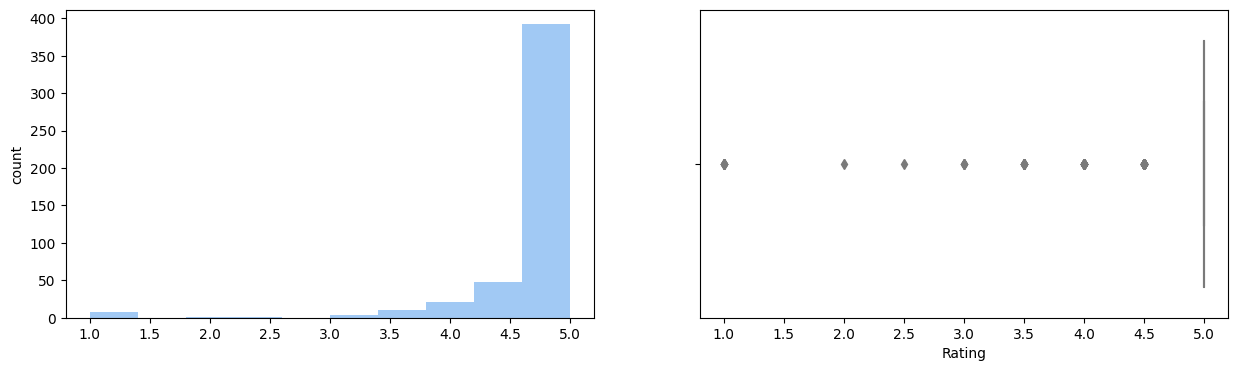

Number of reviews
Skew : 7.56


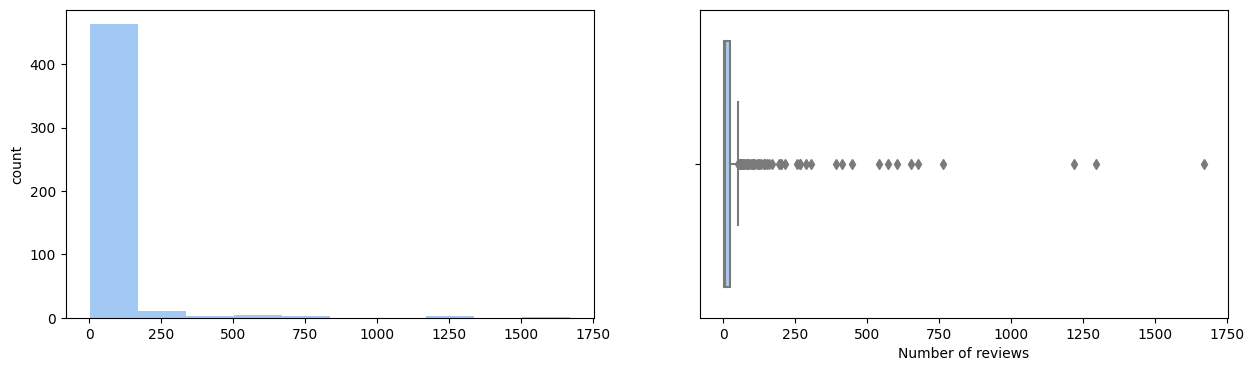

Price
Skew : 13.59


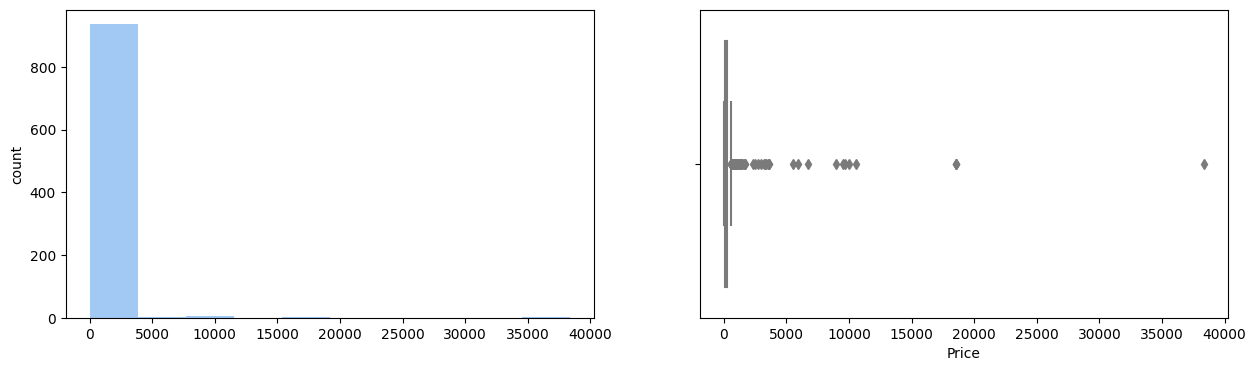

Duration (hrs)
Skew : 13.47


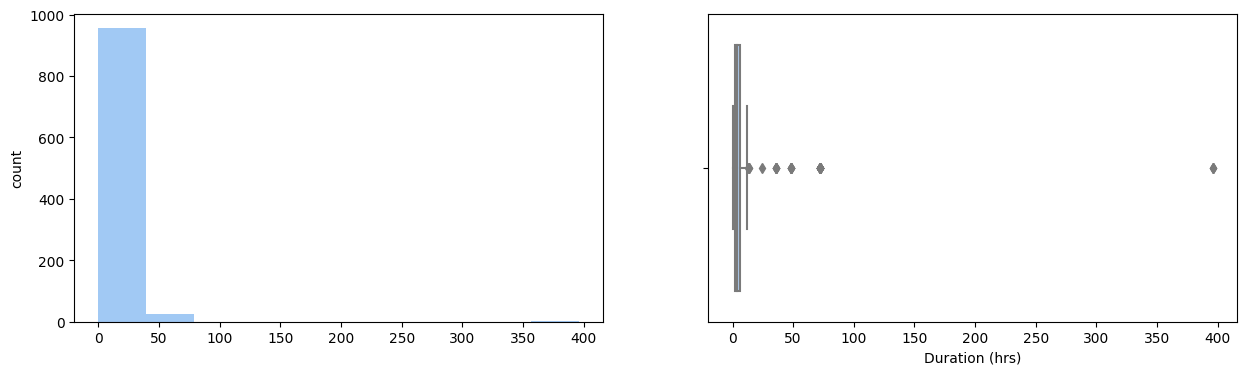

In [4]:
# creating list to store all numeric columns
num_cols = df.select_dtypes(include=np.number).columns.tolist() 
sns.set_palette("pastel")

# creating histogram and boxplot for distribution visualization
for col in num_cols:
    print(col)
    print('Skew :', round(df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.show()

From the above plots, numerical variables show high skewness. 'Rating' is negatively skewed, while other three variables -- 'Number of reviews', 'Price', and 'Duration (hrs)' are positively skewed. Since the variables have high skewness, boxplots also have rather narrow IQR (interquartile range), and thus there are numerous points identified as outliers.

### Univariate Analysis - Categorical Variables

Since 'Type' is a categorical variable, describe() didn't show the distributions by each value - but it seemed like there are several unique values (76 specifically). Visualizing all unique values will be inefficient and unnecessary; therefore, I'd like to know the counts by each type in order to gain more insight.

In [5]:
type_counts = df['Type'].value_counts().reset_index()
type_counts.columns = ['Type', 'count']

type_dat = pd.DataFrame(type_counts)
type_dat

,Type,count
0,Food & Drink,176
1,Historical Tours,105
2,Transportation Services,102
3,Bus Tours,88
4,City Tours,48
...,...,...
71,Car Tours,1
72,Theme Parks,1
73,Dining Experiences,1
74,Sporting Event Tickets & Passes,1


In [6]:
sum(type_dat['count'] > 20)

11

Okay - so from the above exploration of count by 'Type' value, one can deduce that there there are many type values with just one instance each. In fact, only 11 unique types have more than 20 counts.

Skew : 3.91


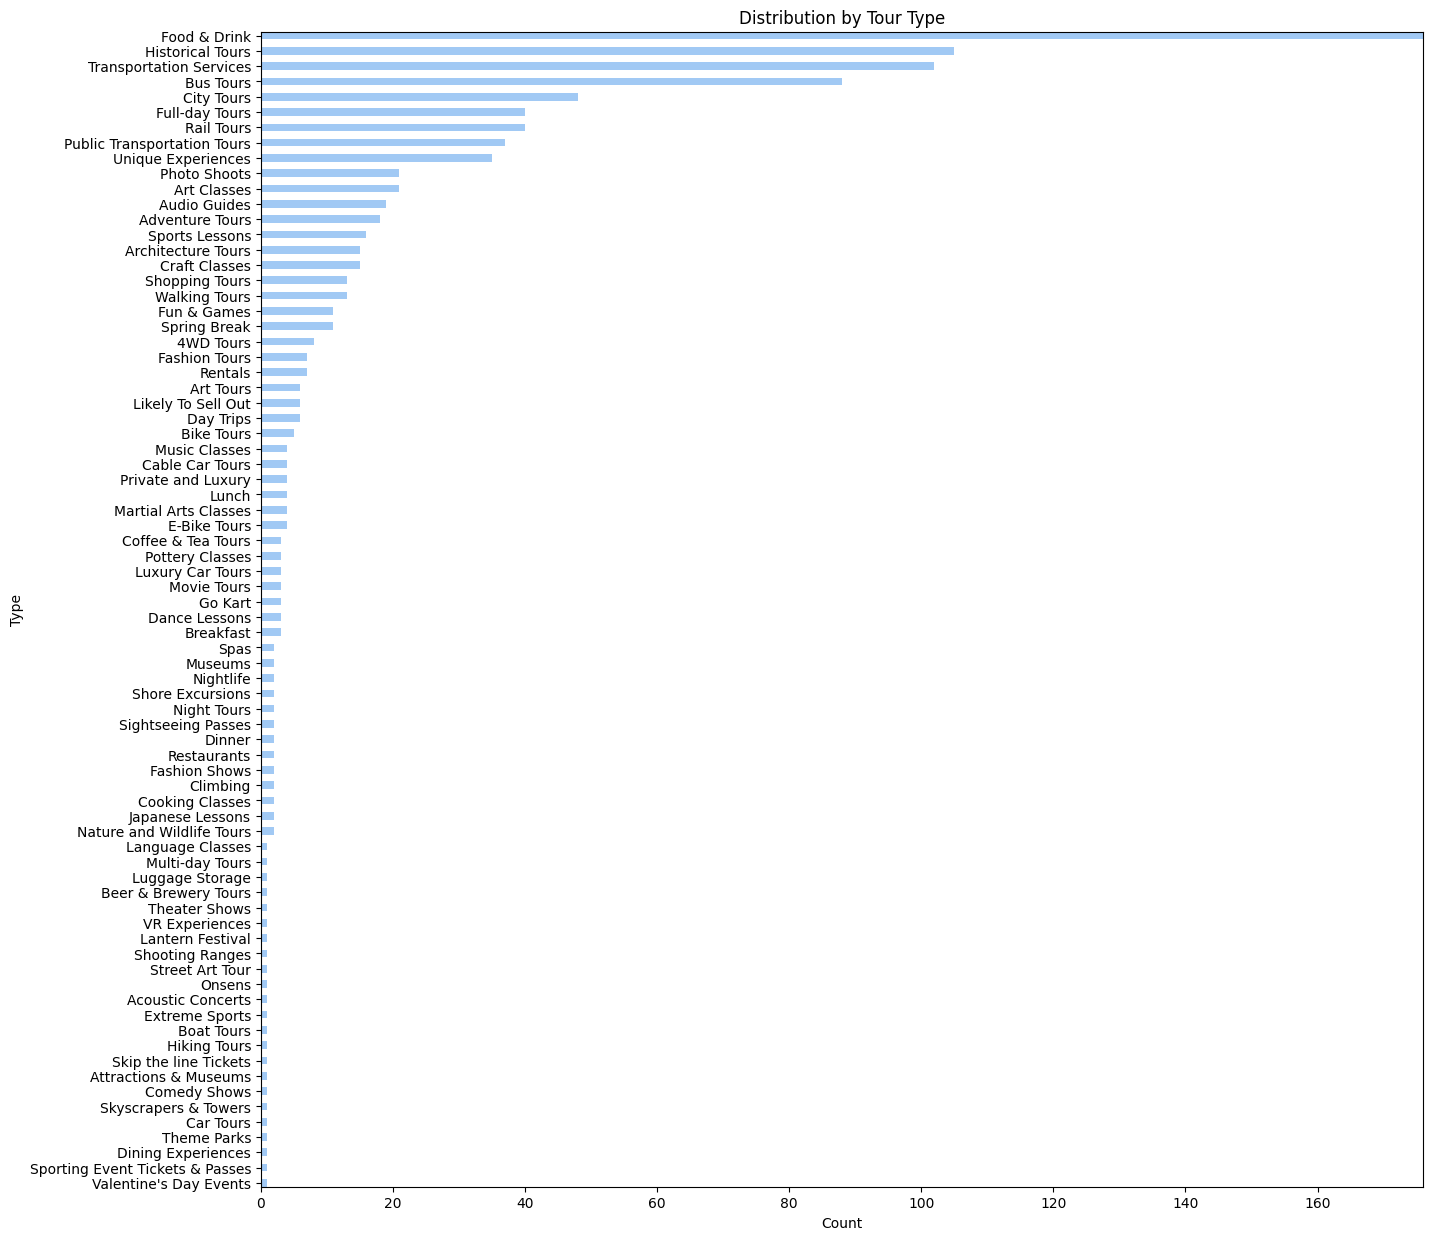

In [7]:
categories = df['Type'].value_counts().index
counts = df['Type'].value_counts().values
categories = categories[::-1]
counts = counts[::-1]

print('Skew :', round(df['Type'].value_counts().skew(), 2))

plt.figure(figsize = (15, 15))
plt.barh(categories, counts, height=0.5)
plt.xlabel('Count')
plt.ylabel('Type')
plt.title('Distribution by Tour Type')
plt.margins(x=0, y=0)

plt.show()

Plotting the distribution of 'Type' variable shows that it also has high skewness with values positively skewed. Those categories with count of only 1 may not contribute to meaningful analysis when I try to understand larger patterns or compare against other numerical variable.

### Bivariate Analysis

<Figure size 1300x1700 with 0 Axes>

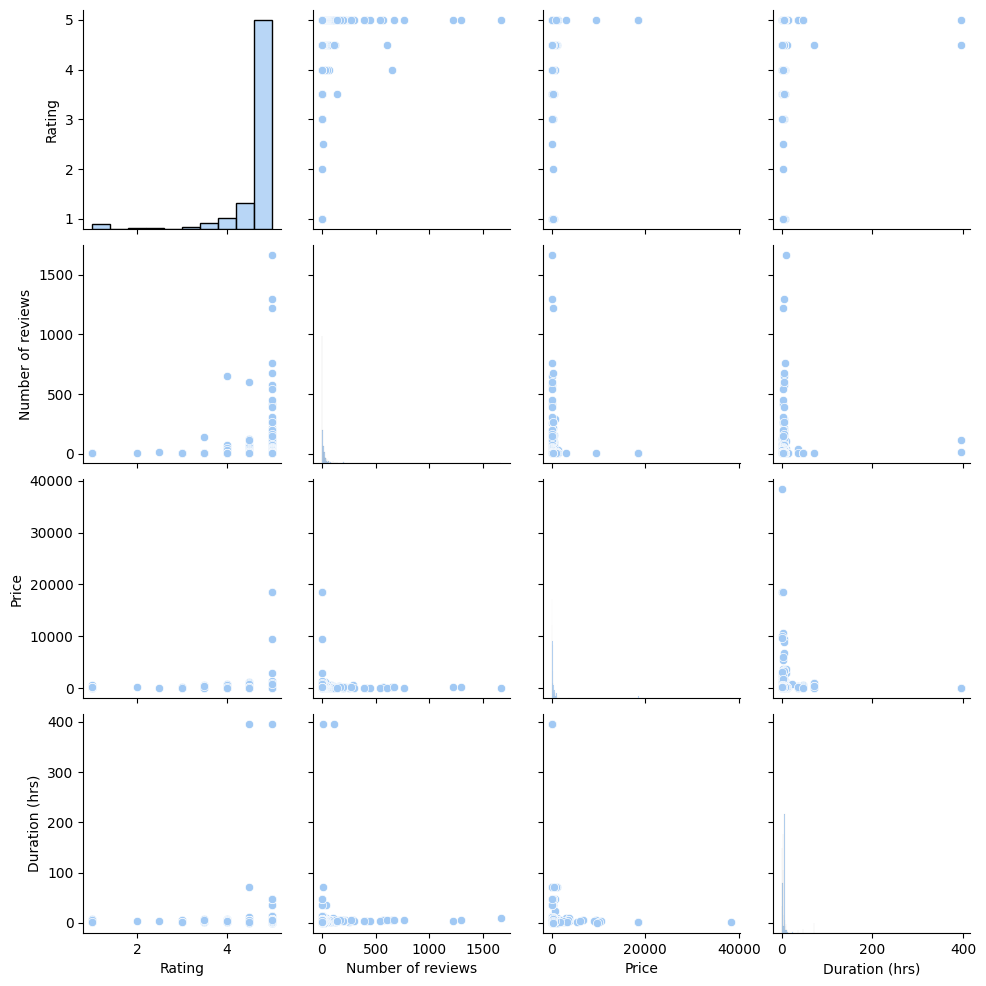

In [8]:
plt.figure(figsize=(13,17))
sns.pairplot(df)
plt.show()

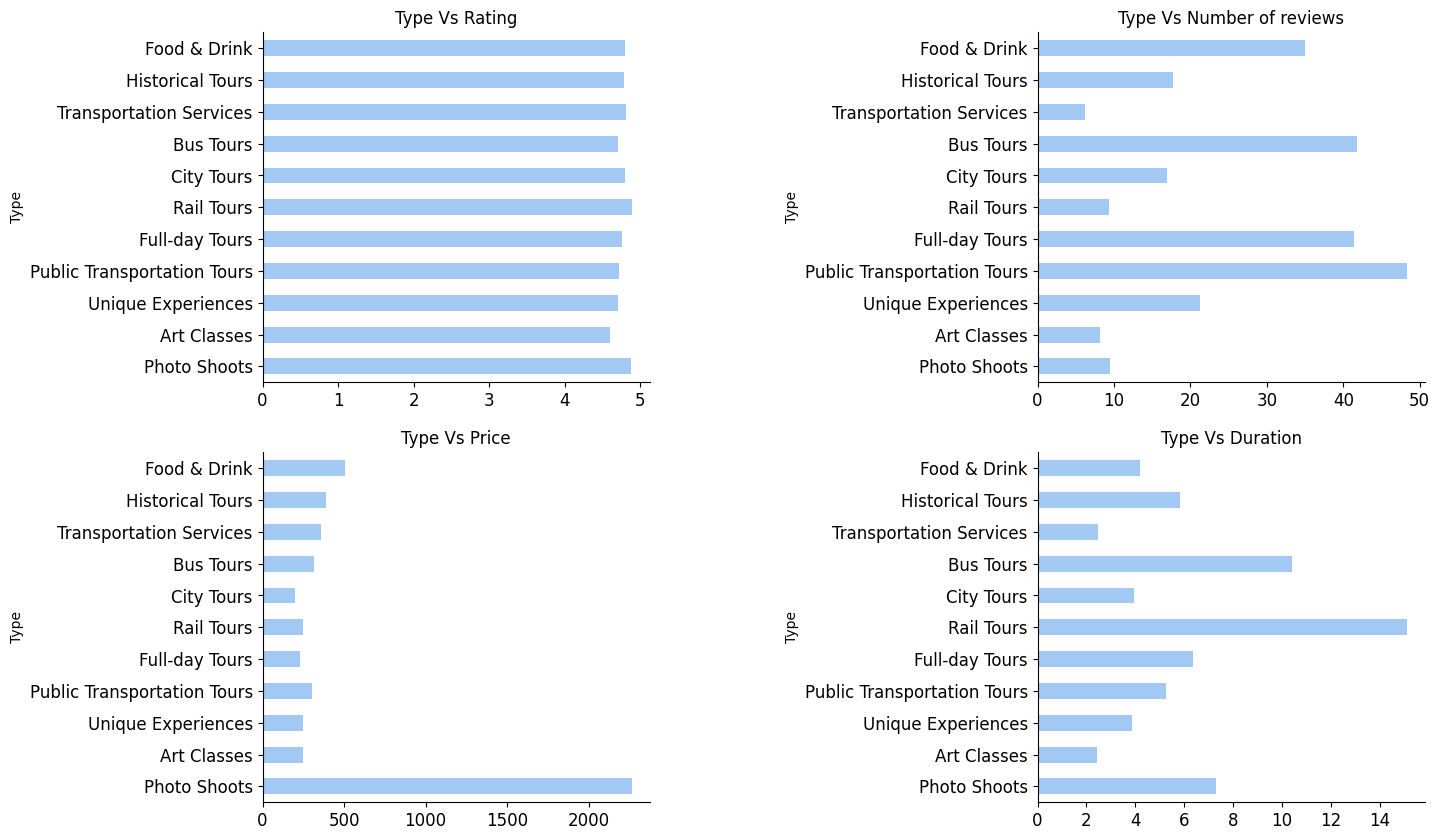

In [9]:
new_df = df.groupby('Type').filter(lambda x: len(x) > 20)

# using 'Type' count as order index to order the categorical variable by descending order of its count
type_order = new_df['Type'].value_counts().index
sorted_type_order = sorted(type_order, key=lambda x: new_df['Type'].value_counts()[x], reverse=False)

# four subplots for type vs. numerical variable
fig, axarr = plt.subplots(2, 2, figsize=(15, 10))
new_df.groupby('Type')['Rating'].mean().loc[sorted_type_order].plot.barh(ax=axarr[0][0], fontsize=12)
axarr[0][0].set_title("Type Vs Rating")

new_df.groupby('Type')['Number of reviews'].mean().loc[sorted_type_order].plot.barh(ax=axarr[0][1], fontsize=12)
axarr[0][1].set_title("Type Vs Number of reviews")

new_df.groupby('Type')['Price'].mean().loc[sorted_type_order].plot.barh(ax=axarr[1][0], fontsize=12)
axarr[1][0].set_title("Type Vs Price")

new_df.groupby('Type')['Duration (hrs)'].mean().loc[sorted_type_order].plot.barh(ax=axarr[1][1], fontsize=12)
axarr[1][1].set_title("Type Vs Duration")

plt.subplots_adjust(wspace=1)
sns.despine()

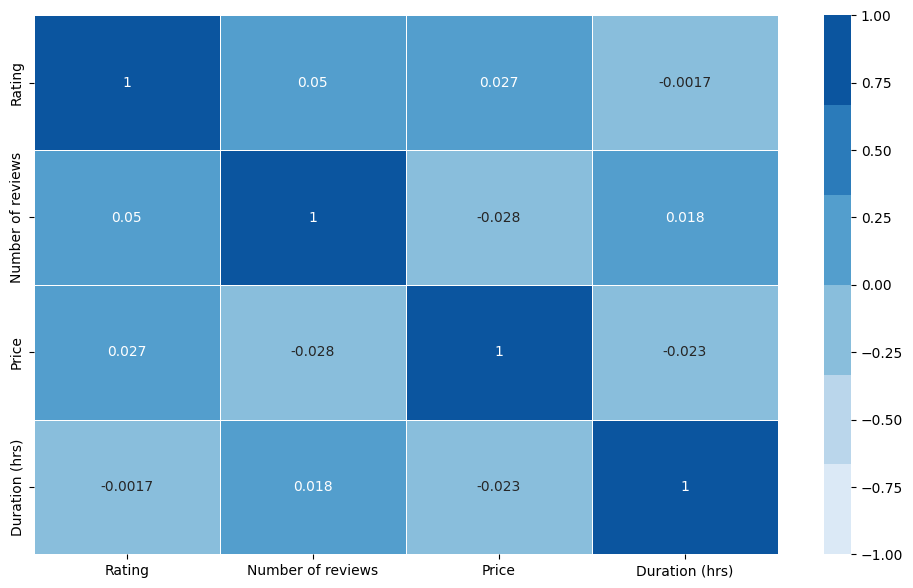

In [10]:
plt.figure(figsize=(12, 7))

sns.heatmap(df.drop(['Tour Name','Type'],axis=1).corr(), annot = True, \
            vmin = -1, vmax = 1, linewidth=.5, cmap=sns.color_palette("Blues"))
plt.show()

### Handling Skewed Data

In [11]:
# Function for log transformation of column
def log_transform(data,col):
    for colname in col:
        data[colname + '_log'] = np.log1p(data[colname])

In [12]:
col_list = ["Rating", "Number of reviews", "Price", "Duration (hrs)"]
log_transform(df, col_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour Name              984 non-null    object 
 1   Type                   983 non-null    object 
 2   Rating                 485 non-null    float64
 3   Number of reviews      485 non-null    float64
 4   Price                  948 non-null    float64
 5   Duration (hrs)         984 non-null    float64
 6   Rating_log             485 non-null    float64
 7   Number of reviews_log  485 non-null    float64
 8   Price_log              948 non-null    float64
 9   Duration (hrs)_log     984 non-null    float64
dtypes: float64(8), object(2)
memory usage: 77.0+ KB


In [13]:
log_col_list = []

for col in col_list:
    log_col = col + "_log"
    log_col_list.append(log_col)

Rating_log
Skew : -5.39


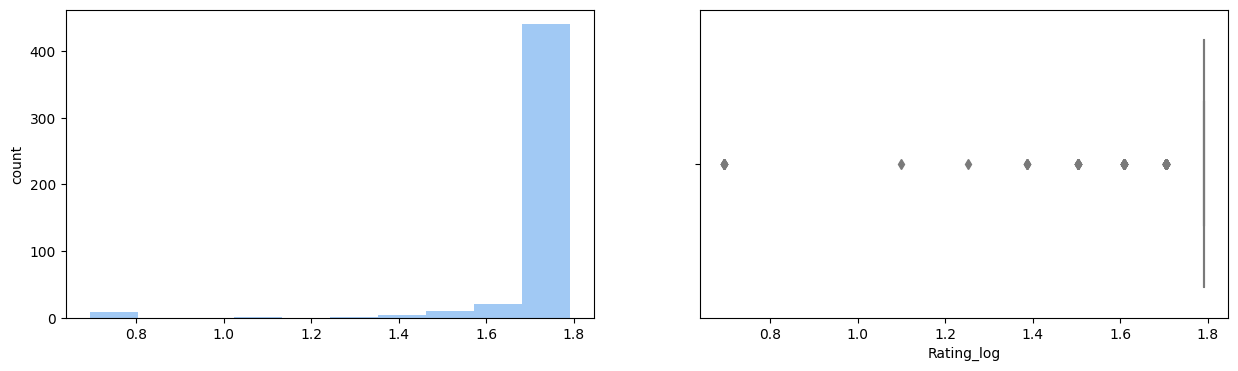

Number of reviews_log
Skew : 1.02


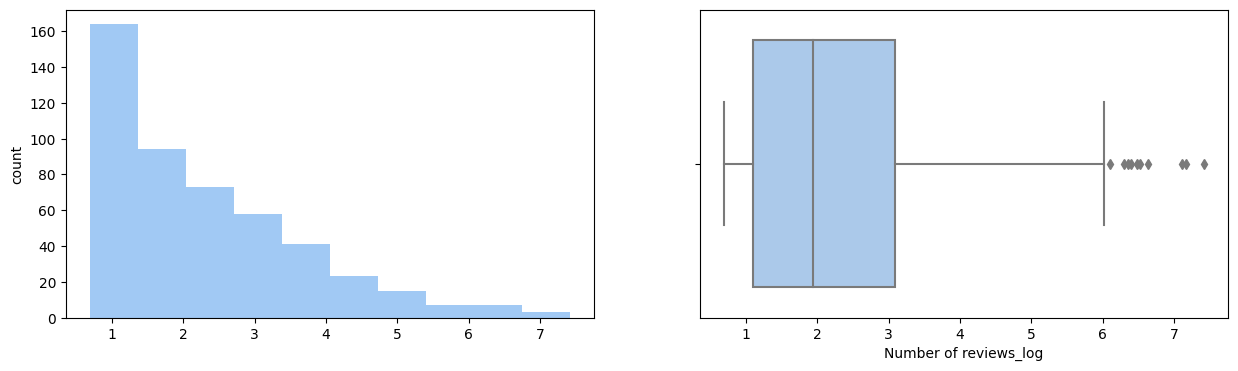

Price_log
Skew : 0.69


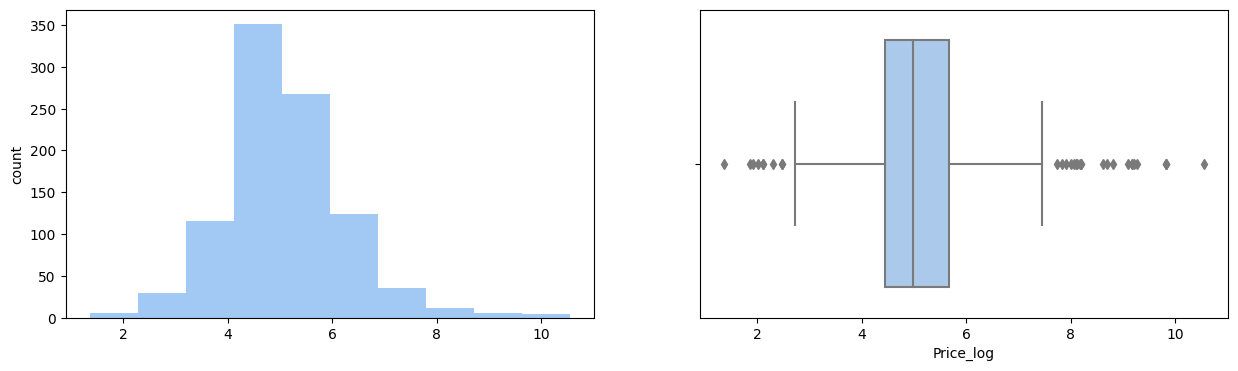

Duration (hrs)_log
Skew : 1.87


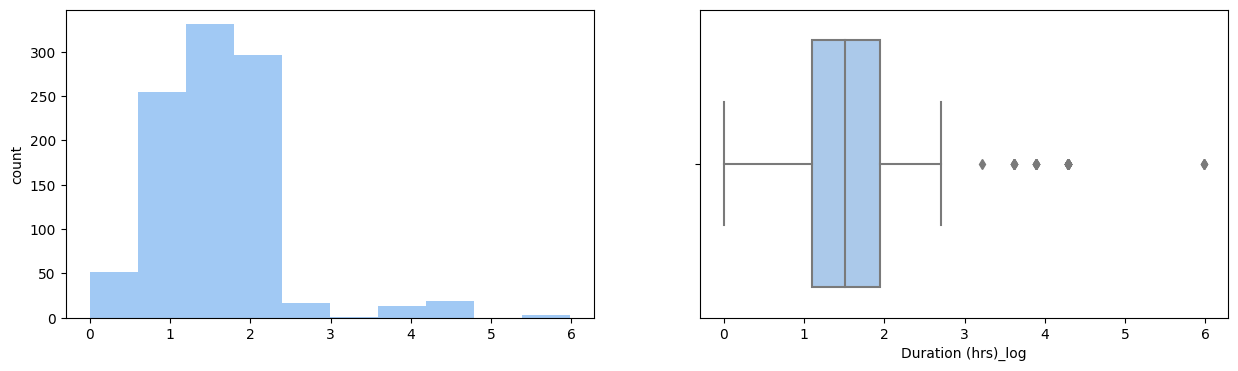

In [14]:
# creating histogram and boxplot for distribution visualization of log transformed columns
for log_col in log_col_list:
    print(log_col)
    print('Skew :', round(df[log_col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    df[log_col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[log_col])
    plt.show()